## Preamble

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import describe
pd.options.display.max_columns = 12
pd.options.display.max_rows = 24

# disable warnings in Anaconda
import warnings
warnings.simplefilter('ignore')

# plots inisde jupyter notebook
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='darkgrid', palette='muted')
color_scheme = {
    'red': '#F1637A',
    'green': '#6ABB3E',
    'blue': '#3D8DEA',
    'black': '#000000'
}

import datetime as dt
import xgboost as xgb

In [3]:
def smape(y_pred, y_true):
    # calculate error
    denom = (abs(y_pred) + abs(y_true)) / 2
    errors = abs(y_pred - y_true) / denom
    return 100 * np.sum(errors) / len(y_true)

In [4]:
def serie_split(s, fcast_len = 90):
    """
    We split our datasets: year 2017 is used for validation and the rest is for training.
    As our goal is to predict the first 90 days of 2018, we use only the first 90 days for validation.
    """
    train = s.iloc[s.index < '2017-01-01']
    test = s.iloc[s.index >= '2017-01-01'].iloc[:fcast_len]
    
    return train, test

## Load data

In [5]:
df = pd.read_csv('../data/train.csv')
df['date'] = pd.to_datetime(df['date'])
df.index = pd.DatetimeIndex(df['date'])

## Feature extraction

In [6]:
from rolling import Rolling

In [7]:
def compute_over_interval(functions, interval):
    return np.array([f(interval) for f in functions])

def features(prev_values, current_date, metadata=None):
    last_2months = prev_values[-60:]
    last_month = prev_values[-30:]
    last_week = prev_values[-7:]
    
    featureset = [
        lambda x: np.median(x),
        #lambda x: np.mean(x),
        #lambda x: np.min(x),
        #lambda x: np.max(x),
        lambda x: np.var(x),
    ]
    
    weekday_v = np.zeros(7)
    weekday_v[current_date.dayofweek] = 1
    
    return np.concatenate([
        #weekday_v,
        last_2months,
        compute_over_interval(featureset, last_month),
        prev_values[:30], # one month almost a year before
    ])


## Training

In [8]:
def train_and_validate(serie):
    r = Rolling(window=365, extract_features=features)

    model = xgb.XGBRegressor(n_jobs=-1)
    
    train, test = serie_split(serie)
    train_X, train_y = r.make_training_data(train)

    model.fit(train_X, train_y)

    y = r.predict(model.predict, train)

    return smape(y, test)

## Run all models

In [9]:
errors = []
for store in range(1,11):
    for item in range(1,51):
        sales = df[(df["store"] == store) & (df["item"] == item)]["sales"]
        error = train_and_validate(sales)
        print(error)
        errors.append(error)

23.87113765793728
16.99160090105278
16.141614314794275
28.64544802575536
26.453506047715074
15.990990711570038
14.017887875891574
12.456157106776926
13.245837265091568
12.687403477013433
11.997499667995571
12.336846490887913
12.313948453848758
14.51198997929609
11.671782363569319
21.336957734547575
17.081446784094602
13.579809834786705
14.899975363219918
14.680308257559899
16.899036250421325
15.791734558427525
17.211455848666738
13.718790631921538
10.703860694996468
14.54913591003008
23.49658293051857
12.131304941515413
14.092751893101362
15.70123948218163
14.023008009442437
17.90507033840503
13.133528274251614
20.855897924540958
10.950528703107484
10.494224777943742
20.463013334106375
12.476130841230422
15.923918245805567
22.576516722950696
23.69048516137382
16.344950834713902
14.451519875800939
19.25797359346662
11.45298399368433
12.369521804596776
22.321977942648832
11.557411972591478
19.476030293772315
13.083247076272398
17.13121087936198
12.13667540317369
13.368218702790463
17.047

16.60247320411955
20.35714418948094
16.196684747066165
13.729617039841477
20.31487748441642
10.302271527138254
13.439512183322044
21.005290011416697
13.450612797022417
16.501114507759482
12.179044066284076
21.556963139298627
12.33327321078022
17.197581458803608
18.979082334131174
20.44431146256982
12.537804134490816
12.922281573790592
12.268027217773907
10.330956229030264
11.425936846481155
10.18338957919352
12.308412556396458
10.56482732403133
13.953919730602312
10.404180612311524
16.883577362962534
19.141086411749345
11.029219866619513
16.45456449090657
11.452054181308702
16.337782557352266
12.429624179847984
15.463232503803608
12.618158391445041
11.520684638919885
14.571931802399169
17.349889283112354
8.456667533909537
10.375180853237094
15.613341780585433
11.83141098177827
14.578257162871653
11.630192467104441
20.65821984344638
12.618388826047353
11.030055298113528
19.357369880038195
11.331278223690086
14.214754751934601
16.09430299783017
23.641589899706215
15.392940603911075
11.35

In [10]:
print(f"SMAPE = {np.mean(errors)}")

SMAPE = 15.37532205938642


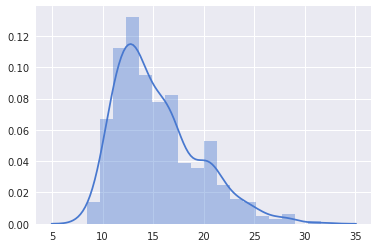

In [11]:
sns.distplot(errors)
plt.savefig('xgboost_features.svg')
plt.show()